HPC4DS: Getting Started with GPUs
========================

---

# Part 1: GPU Libraries

The computationally intensive part of many scientific codes reduces to standard numerical operations, e.g. manipulation of large matrices/vectors, performing Fourier transforms, dealing with sparse linear algebra etc.

In the traditional High Performance Computing (HPC) realm of compiled C/C++/Fortran code, there exists a suite of standard optimised libraries for such things. The CUDA toolkit provides GPU-enabled versions of these, and numba provides Python interfaces to these through the pyculib package which we'll experiment with below.

The advantage of this approach is that no real knowledge of GPU programming is required, we simply replace calls to standard CPU functions with GPU-accelerated equivalents. The disadvantage is that we only accelerate part of the code, and may suffer performance overheads associated with transering data between host and device every time we use one of the functions. We'll explore this penalty below.

---

We'll start by recapping what was in the video, and running through some simple examples.

## cuBLAS

BLAS is the suite of [Basic Linear Algebra Subprograms](http://www.netlib.org/blas/). These come in three levels, for both real and complex data types. 

**Level 1** : Vector-vector operations 

**Level 2** : Matrix-vector operations

**Level 3** : Matrix-matrix operations

On any well-managed HPC system, the local installations of numpy and scipy packages will be built on top of BLAS routines (written in C or Fortran) that have been optimised for the particular hardware in use. Optimised BLAS implementations for CPUs include [OpenBLAS](https://www.openblas.net/), [Atlas](http://math-atlas.sourceforge.net/), [Intel MKL](https://software.intel.com/en-us/mkl) and [AMD ACML](https://developer.amd.com/building-with-acml/).

The CUDA toolkit includes [cuBLAS](https://developer.nvidia.com/cublas), a GPU-accelerated BLAS implementation. Let's compare how this performs in comparison to numpy. Depending on where you are running this notebook, your Numpy installation may have been built using an optimsed BLAS implementation, or it may not. CPU performance will vary wildly depending on what you have. We have run this notebook on a system using OpenBLAS, and where we mention rough timings, they are for this system. 

[Documentation for the pyculib interface to cuBLAS](http://pyculib.readthedocs.io/en/latest/cublas.html)

Let's illustrate this with a simple matrix-matrix multiplication example. The BLAS routine `dgemm` (double precision, general matrix-matrix multiply) performs the following operation.

$$ C = \alpha AB + \beta C $$

where $A$, $B$ and $C$ are matrices and $\alpha$ and $\beta$ are scalars. Other specialised routines are available for matrices with particular structure (e.g. banded, tri-diagonal, symmetric) but we won't worry about that today.

In [1]:
import numba.cuda as cuda
import numpy as np
import pyculib.blas as cublas      # Python interface to cuBLAS, cuFFT, cuSPARSE and cuRAND

# Set size of matrix to work with
size = 3

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# Alpha (we'll leave beta as zero)
alpha = 0.5

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A,B) 

In [2]:
# Query what we need to pass into cublas.gemm
help(cublas.gemm)

Help on function gemm in module pyculib.blas:

gemm(transa, transb, alpha, A, B, beta=0, C=None, stream=None)
    Generalized matrix-matrix multiplication:
    
    C <- alpha*transa(A)*transb(B) + beta*C
    
    'beta' and 'C' are optional on input. Return 'C'.



The first two arguments  specify if we want to use the matrices as supplied ('N' - no operation) or their transpose ('T'). We'll ignore streams for now.

In [3]:
# Perform the multiplication using the GPU and store the results
C_cu = cublas.gemm('N', 'N', alpha, A, B)

A lot just happend behind the scenes there. The numpy arrays have been copied from the host RAM into the device memory, the matrix operation has been performed using the CUDA cores on the device, and the result has been copied back into the numpy array C_cu in the host memory. The device arrays have then been deleted.

Let's be proper programmers and check that both computations gave the same result.

In [4]:
comp = abs(C_cu - C_np)
if  (comp > np.finfo(float).eps).any() : 
    print("Results do not match!")
else:
    print("Results match!")

Results match!


The next thing to investigate is whether this cuBLAS function is any faster. Let's try a more substantial matrix and time how long numpy takes to perform the same operation as above.

In [5]:
from timeit import default_timer as timer  # Timer

size = 1000

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# What is the time before we start the operation?
t1 = timer()

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A,B) 

# What is the time after we finish the operation in milliseconds?
t2 = timer()

# Print time taken
print("Matrix multiplication using numpy took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using numpy took :  16.603588010184467  milliseconds.


To time how long cuBLAS takes to do the same thing we'll use its own timer function.

In [6]:
# First event before we call gemm
t1 = timer()

# Do the multiplication
C_cu = cublas.gemm('N', 'N', alpha, A, B)

# Second event after we call gemm
t2 = timer()

# Print time taken
print("Matrix multiplication using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using cuBLAS took :  29.202698002336547  milliseconds.


As we mentioned above, the time these take depends on the hardware and software available to you. Also, timings inside notebooks can be unreliable, so we don't recommend using them except for a rough idea. 

We've tested this using a NVIDIA Tesla K20c in a 6-core Intel Xeon (2.4GHz) machine, and for 1000x1000 matrices the GPU was about a factor of three faster. Your results may, of course, vary. 

Recall that `cublas.gemm` is copying data to and from the GPU as well as performing the calculation. We can seperate this out into smaller steps to understand where the time is being spent.

First, let's explicitly copy the arrays into the device memory. Note the convention that arrays which live in the device memory are given variable names prefixed with `d_`. For reference in this section see [Section 3.3 of the documentation on Numba for CUDA GPUs](https://numba.pydata.org/numba-doc/dev/cuda/memory.html).

In [7]:
t1 = timer()

# Create new device arrays - first copy A and B
d_A = cuda.to_device(A)
d_B = cuda.to_device(B)

# and create a new array on the device to hold C (faster than copying an empty array from the host)
d_C = cuda.device_array((size,size))

t2 = timer()

# Print time taken
print("Creating device arrays took : ",1000*(t2-t1)," milliseconds.")

Creating device arrays took :  5.756227998062968  milliseconds.


The python interface we're using is clever enough to understand that when we pass device arrays as arguments to cuBLAS functions it should use those instead of copying data over from the host.

In [8]:
t1 = timer()

# Do the multiplication and store result to C_cu on the host
C_cu = cublas.gemm('N', 'N', alpha, d_A, d_B)

t2 = timer()

# Print time taken
print("Matrix multiplication and device to host copy using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication and device to host copy using cuBLAS took :  34.37065897742286  milliseconds.


Remember not to read too much into these timings - these can be quite unreliable when running inside Jupyter notebooks. We'll generate some proper timings in the exercises below.

The take home point is that copying data to and from the device takes time. Best performance will be acheived by doing as much work as possible on the arrays while they are on the device, minimising copies between host and device memory.

## cuBLAS exercises

Assuming the examples so far have run OK, you probably want to spend a little while running some simple examples yourself, either in Notebooks or as scripts. 

### If you have dedicated hardware
Depending on the hardware you have to work with, you may not be able to generate useful timings - because your GPU will underperform. In all cases you need to average the timings from multiple runs to smooth out the variations in timings. If you DO have access to a suitable GPU, the following may be worth exploring:

* How large a matrix is needed before the multiplication is 3x faster on the GPU compared to numpy code? How large for 10x?
* What is the largest speedup you can obtain?
* What is the variability in your timings, what gives rise to this?
* (Advanced) Is the numpy code making use of multiple CPU cores?
* (Advanced) How does performance change if using single rather than double precision?
---
### If you don't
Assuming you can run CUDA code, but don't get terribly useful performance, there is not much point in analysing timings on GPU versus CPU. However, the relative timings on GPU probably still tell you something. Try the following subset of things to explore:
* What is the variability in your timings both on CPU and GPU, what gives rise to this?
* (Advanced) Is the numpy code making use of multiple CPU cores?
* (Advanced) How does performance change if using single rather than double precision?
---

## cuFFT

cuFFT provides GPU-enabled functions to perform the Fast Fourier Transform on 1D, 2D and 3D data. It can be used as a drop-in replacement for (e.g.) numpy.fft routines.

[Documentation for the pyculib interface to cuFFT](http://pyculib.readthedocs.io/en/latest/cufft.html)

We already saw a classic problem in image processing, blurring an image, in previous examples.  We won't repeat that code here; instead we're going to do the same using the GPU for the FFT parts. We are also going to use the same image as we did before. You can go back and add the timing calls to that example if you want comparison times. 

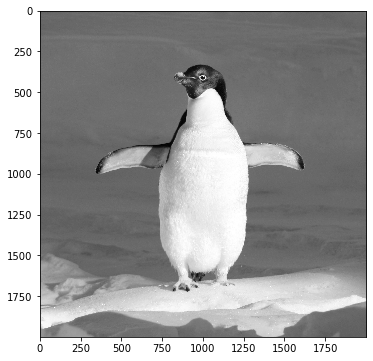

In [9]:
#Load the image and resize it as before
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Open an image file, convert to single colour (greyscale) and resize
img = Image.open('penguin.jpg').convert('L')
dim = 2000
img_resized = img.resize((dim,dim))

# Convert image into numpy array
img_data = np.asarray(img_resized,dtype=float)

# Show the image
plt.figure(figsize = [6, 6])
plt.imshow(img_data,cmap='gray');

In [10]:
# Create the Gaussian to blur with as in the ImageBlur example
width =  0.2 
domain = np.linspace(-5,5,dim)
gauss = np.exp(-0.5*domain**2/(width*width)) 
shift = int(dim/2)
gauss = np.roll(gauss,shift)
gauss2D = gauss[:,np.newaxis] * gauss[np.newaxis,:]

This time we're going to the the FFTs and convolution using the cuFFT library via pyculib. 

There are two ways of doing this, a single function to perform the FFT or a mechanism to create a 'plan' and then invoke this multiple times to perform forward and inverse transforms. This latter mechanism is intended to be familiar for users of the popular library [FFTW (Fastest Fourier Transform in the West)](http://www.fftw.org/).

In [11]:
import pyculib.fft as cufft

In [12]:
# At the time of writing pyculib doesn't seem to correctly deal with real to complex FFTs
# so we add an imaginary part to our data before passing to the GPU routines.
img_data_complex = img_data + 1j * np.zeros((dim,dim))
gauss2D_complex  = gauss2D  + 1j * np.zeros((dim,dim))

# Create new complex arrays to hold the output
img_fft   = np.empty((dim,dim),dtype=complex)
gauss_fft = np.empty((dim,dim),dtype=complex)
img_ifft  = np.empty((dim,dim),dtype=complex)

If we pass host numpy arrays into `cufft.fft()` then the input is automatically copied to the device before the transforms, and the output is copied back afterwards.

In [13]:
# We only need this if using the FFTW-like interface
#plan = cufft.FFTPlan((dim,dim),complex,complex)

t1 = timer()

# FFTW style
#plan.forward(img_data_complex,img_fft)
#plan.forward(gauss2D_complex,gauss_fft)

# Simple style
cufft.fft(img_data_complex,img_fft)
cufft.fft(gauss2D_complex,gauss_fft)

t2 = timer()

# Print time taken
print("Forward fast Fourier Transforms using cuFFT took : ",1000*(t2-t1)," milliseconds.")

AttributeError: /warwick/desktop/2018/software/CUDA/10.1.243-GCC-8.3.0/lib64/libcufft.so.10.1.1.243: undefined symbol: cufftSetCompatibilityMode

In [18]:
# Multiplication in Fourier space
img_conv = img_fft * gauss_fft

In [19]:
# Transform back into real space

t1 = timer()

# FFTW style
#plan.inverse(img_conv,img_ifft)

# Simple style
cufft.ifft(img_conv,img_ifft)

t2 = timer()

print("Inverse fast Fourier Transform using cuFFT took : ",1000*(t2-t1) ," milliseconds.")

Inverse fast Fourier Transform using cuFFT took :  67.1854909742251  milliseconds.


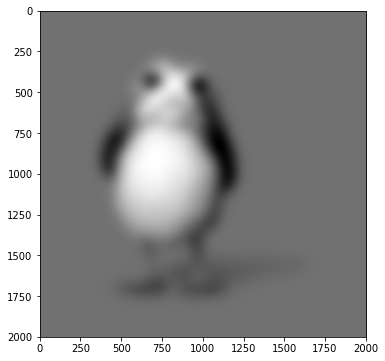

In [20]:
# Display the result of blurring the image using the GPU
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

As with the matrix multiplication example we can seperate the data transfer from the actual Fourier transforms. This will allow us to measure the time taken to perform the transforms seperately from the memory transfer, and (in more involved codes) eliminate unnecessary copies between host and device.

In [21]:
# Copy input data arrays to the device 
d_img_data_complex = cuda.to_device(img_data_complex)
d_gauss2D_complex = cuda.to_device(gauss2D_complex)

# Create new device arrays to hold the output
d_img_fft = cuda.device_array((dim,dim),dtype=np.complex)
d_gauss_fft = cuda.device_array((dim,dim),dtype=np.complex)

# Start the timer
t1 = timer()

# Perform the forward FFTs
cufft.fft(d_img_data_complex,d_img_fft)
cufft.fft(d_gauss2D_complex,d_gauss_fft)
        
t2 = timer()

# Print time taken
print("Forward fast Fourier Transforms using cuFFT took : ",1000*(t2-t1)," milliseconds.")
    
# Copy the result back to the host
img_fft=d_img_fft.copy_to_host()
gauss_fft = d_gauss_fft.copy_to_host()

# Multiply each element in fft_img by the corresponding image in fft_gauss
img_conv = img_fft * gauss_fft

# Copy the product to the device
d_img_conv = cuda.to_device(img_conv)

# Create a new device array to hold the result of the FFT
d_img_ifft = cuda.device_array((dim,dim),dtype=np.complex)

t1 = timer()

# Perform the inverse FFT on the data
cufft.ifft(d_img_conv,d_img_ifft)

t2 = timer()

# Print time taken
print("Inverse fast Fourier Transform using cuFFT took : ",1000*(t2-t1)," milliseconds.")

# Copy result back to host
img_ifft = d_img_ifft.copy_to_host()

Forward fast Fourier Transforms using cuFFT took :  16.29753806628287  milliseconds.
Inverse fast Fourier Transform using cuFFT took :  5.667184945195913  milliseconds.


Wouldn't it be great if we could perform the multiplication at line 26 on the GPU? That way we'd never have to copy `img_fft` and `gauss_fft` back to the host, or copy `img_host` to the device. The entire convolution would be done on the GPU.

That is the job of what is called *kernels*, which we'll look at in part 2!

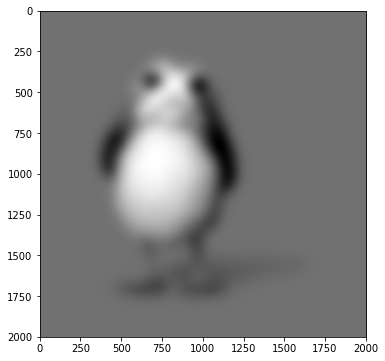

In [22]:
# Check that we still got the correct result
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

## cuFFT exercises

As with the matrix exercises, you may now want to spend some time exploring GPU performance and what affects it. As long as you only consider relative timings, and use an image of suitable size, all of this should work on any suitable hardware. 

Things to investigate:

* How much of the time taken by cuFFT is spent in memory transfers between host and device?

* (Advanced) Investigate the [Python interface to FFTW](https://github.com/pyFFTW/pyFFTW). How does this perform in comparison to numpy and cuFFT?  Does the GPU only appear fast here because the numpy FFT implementation is sub-optimal? You might need to install pyFFTW using `pip install --user pyfftw` inside the environment you launched the notebook from.

* (Advanced) As with the matrix example, how does performance change if using single precision arithmetic?
